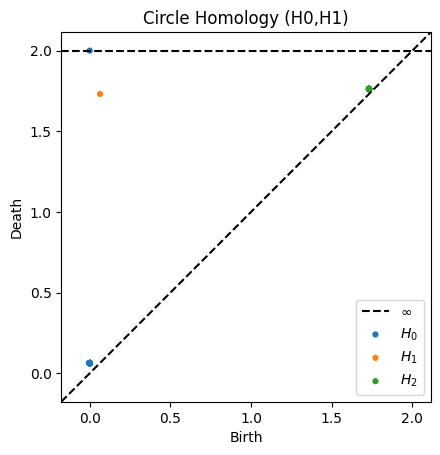

In [5]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('..'))
from topo_trace.homology import compute_persistent_homology, visualize_diagrams
theta = np.linspace(0, 2 * np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)   
circle_points = np.stack([x, y], axis=1)
diagrams = compute_persistent_homology(circle_points)
visualize_diagrams(diagrams, title="Circle Homology (H0,H1)")

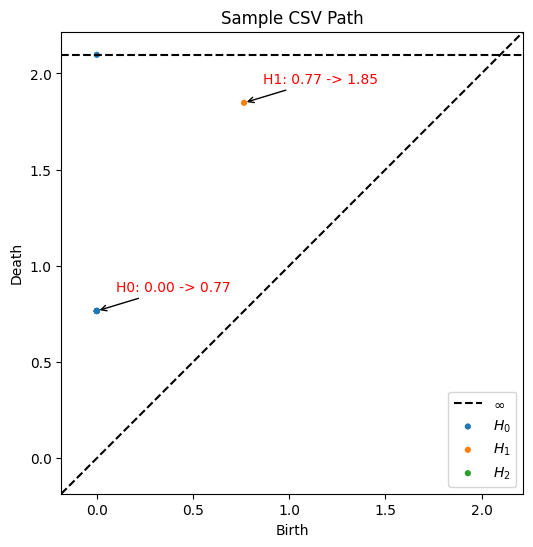

In [32]:
import sys
import os
import csv
sys.path.append(os.path.abspath('..'))
from topo_trace.homology import compute_persistent_homology, visualize_diagrams
from topo_trace.visualizer import plot_annotated_diagram
def load_csv_path(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        data = [list(map(float, row)) for row in reader if row]
    return np.array(data)

points = load_csv_path('../examples/sample_path.csv')
diagrams = compute_persistent_homology(points)
plot_annotated_diagram(diagrams, annotate_top_n=2, title="Sample CSV Path")

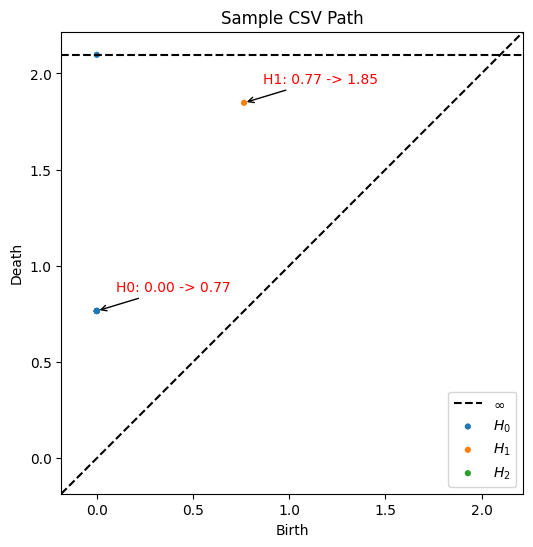

In [33]:
from topo_trace.visualizer import plot_annotated_diagram
fig = plot_annotated_diagram(diagrams, annotate_top_n=2, title="Sample CSV Path")
import matplotlib.pyplot as plt
plt.show()

In [49]:
import numpy as np
from topo_trace.homology import compute_persistent_homology
from topo_trace.graph_loader import load_edge_csv
from topo_trace.gnn_model import GCN
import sys
import os 
sys.path.append(os.path.abspath('..'))
import torch
import csv
def load_csv_path(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        data = [list(map(float, row)) for row in reader if row]
    return np.array(data)

def summarize_diagram(diagram, threshold=0.05):
    if len(diagram) == 0:
        return {
            "num_features": 0,
            "max_lifetime": 0.0,
            "avg_lifetime": 0.0,
            "num_long_cycles": 0,
        }
    birth = diagram[:, 0]
    death = diagram[:, 1]
    lifetime = death - birth
    lifetime = lifetime[np.isfinite(lifetime)]  
    if len(lifetime) == 0:
        return {
            "num_features": 0,
            "max_lifetime": 0.0,
            "avg_lifetime": 0.0,
            "num_long_cycles": 0,
        }

    return {
        "num_features": int(len(lifetime)),
        "max_lifetime": float(np.max(lifetime)),
        "avg_lifetime": float(np.mean(lifetime)),
        "num_long_cycles": int(np.sum(lifetime > threshold)),
    }

def summarize_all(diagrams):
    summary = {}
    for dim, diagram in enumerate(diagrams):
        summary[f"H{dim}"] = summarize_diagram(diagram)
    return summary

topo_features = []
gnn_embeddings = []
labels = []
label_dict = {
    "circle_path.csv": 0,
    "scatter_path.csv": 1,
    "tx_loop.csv": 1,
    "tx_star.csv": 1,
    "zigzag_path.csv": 0,
    "sample_path.csv": 0,
    "room_loop.csv": 0,
}

model = GCN(in_dim=5, hidden_dim=8, out_dim=4)  # adjust input dim if needed

for fname, label in label_dict.items():
    # ---- TopoTrace Path Handling ----
    points = load_csv_path(f"./{fname}")
    diag = compute_persistent_homology(points)
    summary = summarize_all(diag)
    topo_vector = []
    for h in ["H0", "H1", "H2"]:
        for k in ["num_features", "max_lifetime", "avg_lifetime", "num_long_cycles"]:
            topo_vector.append(summary.get(h, {}).get(k, 0.0))

    # ---- GNN Graph Handling ----
    if "graph" in fname:
        data, _ = load_edge_csv(f"examples/{fname}")
        embedding = model(data.x, data.edge_index).detach().numpy()
    else:
        embedding = np.zeros(4)  # 4-dim dummy vector if no GNN

    topo_features.append(topo_vector)
    gnn_embeddings.append(embedding)
    labels.append(label)

from topo_trace.hybrid_model import HybridClassifier

clf = HybridClassifier()
clf.fit(np.array(topo_features), np.array(gnn_embeddings), labels)
# Load a test trace
test_points = load_csv_path("./scatter_path.csv")
test_diag = compute_persistent_homology(test_points)
test_summary = summarize_all(test_diag)

flat_topo = []
for h in ["H0", "H1", "H2"]:
    for k in ["num_features", "max_lifetime", "avg_lifetime", "num_long_cycles"]:
        flat_topo.append(test_summary.get(h, {}).get(k, 0.0))

# If graph, embed it; if not, use zero vector
test_gnn = np.zeros(4)

# Predict
pred = clf.predict([flat_topo], [test_gnn])
print("Prediction:", "Anomalous" if pred[0] else "Normal")


Prediction: Anomalous


In [31]:
from topo_trace.homology import compute_persistent_homology, visualize_diagrams
import sys
import os
sys.path.append(os.path.abspath('..'))
import csv
def load_csv_path(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        data = [list(map(float, row)) for row in reader if row]
    return np.array(data)

def summarize_diagram(diagram, threshold=0.05):
    
    if len(diagram) == 0:
        return {
            "num_features": 0,
            "max_lifetime": 0.0,
            "avg_lifetime": 0.0,
            "num_long_cycles": 0,
        }
    birth = diagram[:, 0]
    death = diagram[:, 1]
    lifetime = death - birth
    lifetime = lifetime[np.isfinite(lifetime)]

    return {
        "num_features": len(lifetime),
        "max_lifetime": np.max(lifetime),
        "avg_lifetime": np.mean(lifetime),
        "num_long_cycles": np.sum(lifetime > threshold),
    }

def summarize_all(diagrams):
    summary = {}
    for dim, diagram in enumerate(diagrams):
        summary[f"H{dim}"] = summarize_diagram(diagram)
    return summary

points = load_csv_path('../examples/sample_path.csv')
diagrams = compute_persistent_homology(points)
summary = summarize_all(diagrams)

from pprint import pprint
pprint(summary)

{'H0': {'avg_lifetime': np.float64(0.7653090953826904),
        'max_lifetime': np.float64(0.7653090953826904),
        'num_features': 7,
        'num_long_cycles': np.int64(7)},
 'H1': {'avg_lifetime': np.float64(1.082310438156128),
        'max_lifetime': np.float64(1.082310438156128),
        'num_features': 1,
        'num_long_cycles': np.int64(1)},
 'H2': {'avg_lifetime': 0.0,
        'max_lifetime': 0.0,
        'num_features': 0,
        'num_long_cycles': 0}}
